# Modeling marketing attribution

Author: Taylor Larkin \
Version Date: 2025-09-10

Marketing attribution can be defined as the process of assigning credit to certain marketing activities (e.g., spending) as they contribute towards a desired goal (e.g., increases in revenue). Understanding how much these marketing activities contribute enables stakeholders to make better budget allocation decisions. However, in today’s world, marketing teams have many avenues to spend their marketing dollars, and it can be a daunting task to figure out which avenues are playing the largest role towards optimizing the key performance indicator (KPI) of interest. Model-based approaches can help sift through all this information in a rigorous and efficient way, leading to faster decision-making.

### The challenge

One of the most common ways to understand the attribution from each marketing channel of interest is to do live A/B testing (e.g., incrementality testing). That is, expose one group to marketing spend and another very similar group in nature to no marketing spend. Assuming all the sources of variability between the groups are reasonably satiated, you can measure a KPI (e.g., revenue) for both over a window of time and take the difference between them. This difference gives you information as to the lift that your marketing efforts had during the experimental window.

While the benefit of this method is deriving attribution via live-testing, some disadvantages include:

- A/B testing can be resource and time-intensive (e.g., you need many weeks to get a good picture of the differences, especially in different times of the year).
- Derived insights can only be gleaned from the experimental window (i.e., if you’re testing only for 10 weeks, you only have 10 weeks worth of data from the procedure).
- Many factors can influence business results such as competition, economy, local events, etc., so it can be difficult to truly isolate the incremental lift from marketing (i.e., experimental design is hard to do outside of a laboratory).

With the help of model-based approaches, you can leverage historical data to approximate this A/B testing procedure to collect insights from the past to inform future decisions.

### Model-based approaches

In order to emulate the aforementioned A/B testing procedure (and assuming revenue is your KPI of interest), you need to be able to know the difference in revenue between when you expose your customer base to marketing and when you don't. While it’s possible to have days historically where you didn’t have any marketing spend, it’s more likely that you had some level of marketing spend activity each day. Hence, it’s impossible to go back in time to understand what revenue would have been without any marketing spend on each day in the past. This is where model-based approaches can help.

For the purposes of this accelerator, you can think of a “model” as “a set of steps a computer takes to find patterns or make decisions.” Different types of models exist, but the focus here will be on machine learning models, which are primarily used for predicting information you don’t know (such as revenue associated with no marketing spend). Specifically for marketing attribution, the steps may include:

1. Acquire historical revenue and spending data at the desired granularity (weekly, monthly, etc.)
2. Build a machine learning model that tries to learn how to predict historical revenue based on your historical spend (and other factors that can help explain revenue like holidays, promotions, economic indicators, etc.).
3. Once your model has learned all it can from your historical data, you can begin using it to answer what-if questions like, “what would my revenue be if I increase spending in this marketing channel?” or “what would my revenue have been if I didn’t do any marketing spend whatsoever on this day?”
4. After you estimate what revenue would have been with no marketing spend each day in your historical data using the model, you can compare this value to the actual revenue on the given day to understand the total lift in dollars due to your marketing efforts.
5. Once the total lift is estimated, you can allocate this out to the individual marketing channels with the help of explanatory tools like [Shapley values](https://christophm.github.io/interpretable-ml-book/shapley.html).

Having this machine learning model gives you the ability to help answer questions you normally wouldn’t be able to know about our historical data. It can also be used to understand future what-if scenarios too (e.g., "if I applied this allocation of spend across my marketing channels on this day in the future, what would my predicted revenue be?") and budget optimization (e.g., "out of the possible allocation strategies I have, which one will increase my revenue the most?").

### How DataRobot helps

DataRobot can help with marketing attribution use cases by:

1. Making building machine learning models incredibly easy
2. Providing a Python API client that makes building custom workflows repeatable and scalable
3. Having a suite of interpretability tools for each machine learning model (including SHAPley values)
4. Having connectors to databases such as Snowflake
5. Having mechanisms to create straightforward custom applications to consume results (or can write results back to the database for consumption of an internally-built dashboard)
   
These are just a few examples how DataRobot can streamline this process. Ultimately, a variety of ways exist for tackling marketing attribution and the process described below is just one way DataRobot has helped customers in the past. It is by _no_ means the only way to do marketing attribution use cases.

## Setup

### Import libraries

In [1]:
%load_ext autoreload
%autoreload 2

from collections import defaultdict
from itertools import product
import time

import datarobot as dr
from datarobot.insights.shap_impact import ShapImpact
from helpers import (
    add_adstock_features,
    add_event_context_features,
    add_lag_features,
    add_rolling_means,
    apply_normalization,
    delayed_adstock_transformation,
    extract_channel_name,
    extract_values_and_convert,
    plot_summary,
    post_process_incremental_values,
    prepare_summary_data,
    reformat_prediction_row,
    run_all_data_checks,
)
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

pd.set_option("display.max_columns", None)

In [2]:
# Check version
dr.__version__

'3.7.1'

### Connect to DataRobot

In [3]:
# Connect to DR
dr.Client()

### Set parameters

Define some important column names for easier reference throughout the code. Note that columns will be referenced to as ["features"](https://docs.datarobot.com/en/docs/get-started/glossary/index.html#feature) throughout this notebook.

In [4]:
# Parameters
DATE_COL = "DATE"
TARGET_COL = "revenue"
EVENT_COL = "holiday"

SPEND_COLS = [
    "tv_S",
    "ooh_S",
    "print_S",
    "search_S",
    "facebook_S",
]
CONTEXT_COLS = ["competitor_sales_B"]

## Load data

The dataset used in this accelerator comes from an [open-source marketing mix modeling package](https://facebookexperimental.github.io/Robyn/docs/welcome) where the goal is to predict revenue from spending in five different paid media marketing channels:

1. Television (`tv_S`): 
2. Out-of-home (`ooh_S`)
3. Print (`print_S`)
4. Search (`search_S`)
5. Meta (`facebook_S`)

This accelerator also uses `competitor_sales_B` as an example of a context feature (i.e., a non-marketing channel feature that can help explain revenue). You'll also use the associated calendar file to encode event information to give additional context to the model.

In [5]:
# Load data
df = pd.read_csv(
    "https://raw.githubusercontent.com/facebookexperimental/Robyn/refs/heads/main/python/src/robyn/tutorials/resources/dt_simulated_weekly.csv",
    usecols=[DATE_COL, TARGET_COL] + SPEND_COLS + CONTEXT_COLS,
    parse_dates=[DATE_COL],
)

# Ensure it's sorted from oldest to newest
df = df.sort_values(DATE_COL).reset_index(drop=True)
df

,DATE,revenue,tv_S,ooh_S,print_S,search_S,competitor_sales_B,facebook_S
0,2015-11-23,2.754372e+06,22358.346667,0.000000,12728.488889,0.000000,8125009,7607.132915
1,2015-11-30,2.584277e+06,28613.453333,0.000000,0.000000,4133.333333,7901549,1141.952450
2,2015-12-07,2.547387e+06,0.000000,132278.400000,453.866667,3786.666667,8300197,4256.375378
3,2015-12-14,2.875220e+06,83450.306667,0.000000,17680.000000,4253.333333,8122883,2800.490677
4,2015-12-21,2.215953e+06,0.000000,277336.000000,0.000000,3613.333333,7105985,689.582605
...,...,...,...,...,...,...,...,...
203,2019-10-14,2.456240e+06,0.000000,32230.933333,20496.488889,14946.666667,7612762,0.000000
204,2019-10-21,2.182825e+06,20655.680000,0.000000,0.000000,13826.666667,6701667,4454.152517
205,2019-10-28,2.377707e+06,2931.000000,7516.800000,2330.133333,15293.333333,7688920,0.000000
206,2019-11-04,2.732825e+06,2993.733333,0.000000,3206.844444,17880.000000,8815710,0.000000


In [6]:
# Loading calendar file
# Using "DE" as done in the code examples
df_cal = pd.read_csv(
    "https://raw.githubusercontent.com/facebookexperimental/Robyn/refs/heads/main/python/src/robyn/tutorials/resources/dt_prophet_holidays.csv"
)

# Subsetting to relevant years and country
df_cal = df_cal.loc[
    (df_cal["country"] == "DE")
    & (df_cal["year"] > (df["DATE"].dt.year.min() - 1))
    & (df_cal["year"] < (df["DATE"].dt.year.max() + 1))
].reset_index(drop=True)

# Rename to match
df_cal = df_cal.rename({"ds": DATE_COL}, axis=1)
df_cal

,DATE,holiday,country,year
0,2015-01-01,New Year's Day,DE,2015
1,2015-04-03,Good Friday,DE,2015
2,2015-04-06,Easter Monday,DE,2015
3,2015-05-01,Labor Day,DE,2015
4,2015-05-14,Ascension Day,DE,2015
5,2015-05-25,Whit Monday,DE,2015
6,2015-10-03,German Unity Day,DE,2015
7,2015-12-25,Christmas Day,DE,2015
8,2015-12-26,Second Day of Christmas,DE,2015
9,2016-01-01,New Year's Day,DE,2016


### Data validation and exploration

This code performs some basic checks of the underlying data. Verify that there are no missing values and that you have all the expected dates present. Additionally, you'll plot revenue over time.

In [7]:
# Run all checks
run_all_data_checks(df, date_col=DATE_COL, freq="W-MON", required_columns=None)

CHECKING FOR MISSING VALUES
✅ No missing values found in the 8 checked columns

CHECKING FOR MISSING DATES
✅ No missing dates found with frequency 'W-MON'

OVERALL RESULT: ✅ PASSED


{'missing_values': {'passed': True, 'details': {}},
 'missing_dates': {'passed': True, 'details': [], 'frequency': 'W-MON'}}

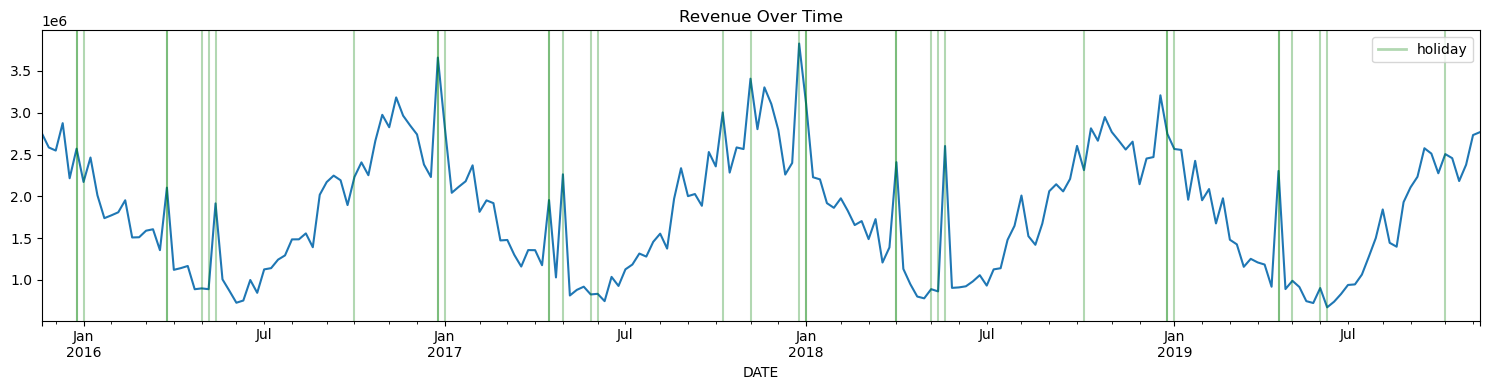

In [8]:
# Get dates of events to plot
event_dates = df_cal[DATE_COL].tolist()

# Create figure and axis objects
fig, ax = plt.subplots(figsize=(15, 4))

# Plot revenue data
df.set_index(DATE_COL)[TARGET_COL].plot(ax=ax, title="Revenue Over Time")

# Add vertical lines for holidays and create a label for the legend
for d in event_dates:
    ax.axvline(d, color="green", alpha=0.3)

# Add a custom legend entry for the holiday lines
custom_lines = [Line2D([0], [0], color="green", lw=2, alpha=0.3)]
ax.legend(custom_lines, [EVENT_COL])

plt.tight_layout()
plt.show()

## Feature engineering

After validating and modifying the underlying dataset, perform feature engineering to better represent the data to the model. In this accelerator, you break this out into three categories:

1. Target-related data
2. Event-related data
3. Spend-related data

The first two categories are more generic feature engineering tasks while the third is specific to marketing attribution. 

In [9]:
# Separate out the raw data from the transformed data
df_train = df.set_index(DATE_COL)[[TARGET_COL] + CONTEXT_COLS]
df_train

,revenue,competitor_sales_B
DATE,,
2015-11-23,2.754372e+06,8125009
2015-11-30,2.584277e+06,7901549
2015-12-07,2.547387e+06,8300197
2015-12-14,2.875220e+06,8122883
2015-12-21,2.215953e+06,7105985
...,...,...
2019-10-14,2.456240e+06,7612762
2019-10-21,2.182825e+06,6701667
2019-10-28,2.377707e+06,7688920


### Target-related data

"Target" here simply means the KPI of interest that you're going to model against. The target-related feature engineering will be simple lags and rolling means. Adding this information can help account for past target behavior impacting current target values and acts as proxies for information you're not able to collect. Lags can help capture specific time-delayed relationships while rolling means smooth out noise / highlights trends.

In [10]:
# Define windows for lags and rolling statistics
lag_periods = [1, 4, 12]  # 1 week, 1 month, 1 quarter
rolling_windows = [4, 12]  # 1 month, 1 quarter

# Apply lags
df = add_lag_features(
    df=df,
    target_col=TARGET_COL,
    lag_periods=lag_periods,
    time_unit="week",
    date_col=DATE_COL,
)

# Apply rolling means
df = add_rolling_means(
    df=df,
    target_col=TARGET_COL,
    rolling_windows=rolling_windows,
    time_unit="week",
    date_col=DATE_COL,
)

# Join them in
cols_to_add = [x for x in df.columns if x.startswith(f"{TARGET_COL} (")]
df_train = df_train.join(df.set_index(DATE_COL)[cols_to_add])

# Check
df_train

,revenue,competitor_sales_B,revenue (1 week ago),revenue (4 weeks ago),revenue (12 weeks ago),revenue (4 week average),revenue (12 week average)
DATE,,,,,,,
2015-11-23,2.754372e+06,8125009,NaN,NaN,NaN,NaN,NaN
2015-11-30,2.584277e+06,7901549,2.754372e+06,NaN,NaN,NaN,NaN
2015-12-07,2.547387e+06,8300197,2.584277e+06,NaN,NaN,NaN,NaN
2015-12-14,2.875220e+06,8122883,2.547387e+06,NaN,NaN,NaN,NaN
2015-12-21,2.215953e+06,7105985,2.875220e+06,2.754372e+06,NaN,2.690314e+06,NaN
...,...,...,...,...,...,...,...
2019-10-14,2.456240e+06,7612762,2.505162e+06,2.575148e+06,1.278223e+06,2.466720e+06,1.966783e+06
2019-10-21,2.182825e+06,6701667,2.456240e+06,2.510952e+06,1.500828e+06,2.436993e+06,2.064951e+06
2019-10-28,2.377707e+06,7688920,2.182825e+06,2.275620e+06,1.843118e+06,2.354962e+06,2.121784e+06


### Event-related data

To capture the temporal influence of significant events on revenue, implement a nearest-event feature engineering approach that creates two key features: `Event (Days Until Next)` (signed distance where negative values indicate days before an event, zero is the day of the event, and positive values indicate days after) and `Event (Next Name)` (the name of the next event). The former allows the model to learn if days leading up to or away from an event is important while the latter allows the model to learn differences between the actual events. This is certainly not the only way to encode this information, feel free to do what's best for your use case. Note that DataRobot will generate features like the month and day of month automatically.

In [11]:
# Negative values - days leading up to event
# Zero values - day of event
# Postive values - day away from event
df = add_event_context_features(
    df=df,
    event_df=df_cal,
    event_col=EVENT_COL,
    date_col=DATE_COL,
    distance_col_name="Event (Days Until Next)",
    event_name_col="Event (Next Name)",
)

# Join them in
cols_to_add = ["Event (Days Until Next)", "Event (Next Name)"]
df_train = df_train.join(df.set_index(DATE_COL)[cols_to_add])

# Check
df_train

,revenue,competitor_sales_B,revenue (1 week ago),revenue (4 weeks ago),revenue (12 weeks ago),revenue (4 week average),revenue (12 week average),Event (Days Until Next),Event (Next Name)
DATE,,,,,,,,,
2015-11-23,2.754372e+06,8125009,NaN,NaN,NaN,NaN,NaN,-32.0,Christmas Day
2015-11-30,2.584277e+06,7901549,2.754372e+06,NaN,NaN,NaN,NaN,-25.0,Christmas Day
2015-12-07,2.547387e+06,8300197,2.584277e+06,NaN,NaN,NaN,NaN,-18.0,Christmas Day
2015-12-14,2.875220e+06,8122883,2.547387e+06,NaN,NaN,NaN,NaN,-11.0,Christmas Day
2015-12-21,2.215953e+06,7105985,2.875220e+06,2.754372e+06,NaN,2.690314e+06,NaN,-4.0,Christmas Day
...,...,...,...,...,...,...,...,...,...
2019-10-14,2.456240e+06,7612762,2.505162e+06,2.575148e+06,1.278223e+06,2.466720e+06,1.966783e+06,11.0,German Unity Day
2019-10-21,2.182825e+06,6701667,2.456240e+06,2.510952e+06,1.500828e+06,2.436993e+06,2.064951e+06,18.0,German Unity Day
2019-10-28,2.377707e+06,7688920,2.182825e+06,2.275620e+06,1.843118e+06,2.354962e+06,2.121784e+06,25.0,German Unity Day


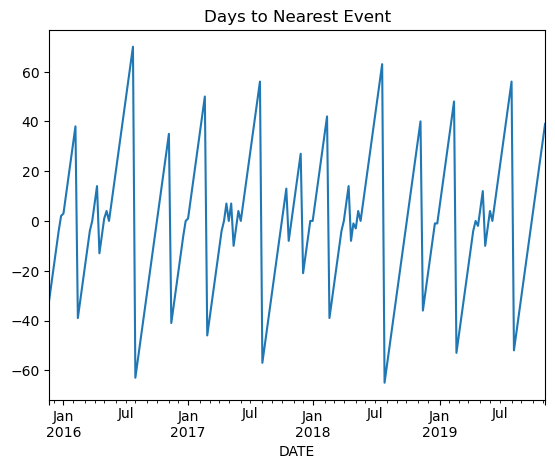

In [12]:
# Checking what this transformation looks like
df_train["Event (Days Until Next)"].plot(title="Days to Nearest Event")
plt.show()

### Spend-related

Arguably, the most important feature engineering step is capturing the carry-over and delayed effects that spending can have. Spending in a channel today will have some effect beyond the current day, or it may not make much of an impact until later on. Capturing these dynamics are crucial for attribution use cases. One of the most common ways to implement this is via an adstock transformation, which tries to account for things like the length of a media effect, the peak of max impact spending can have on the target, and how fast this effect decays in the coming days. The formulation used here can be found in section 2 of [this paper](https://research.google/pubs/bayesian-methods-for-media-mix-modeling-with-carryover-and-shape-effects/), which is based on a weighted average of the current time period `L` and the previous `L - 1` weeks. Generally-speaking, these parameters are set via subject-matter expertise but can also be estimated from the data. Given that often times it's hard to know what the exact effect is, we generate a grid of values to try, apply them to each channel, and then using DataRobot's [univariate importance scores](https://docs.datarobot.com/en/docs/workbench/wb-experiment/manage-experiments/experiment-data.html#importance-score), pick the one with the highest association with the target.

#### Define search space

In [13]:
# Construct a grid of values to test
L = [4, 8, 12]  # length of media effect (in weeks)
P = [0, 1, 2, 3]  # what week the media effect peaks (in weeks)
D = [0.6, 0.8]  # the rate of decay of the media effects (values 0 < D < 1)

# Create the Cartesian product
combinations = list(product(L, P, D))

# Convert to a pandas DataFrame
df_adstock_grid = pd.DataFrame(combinations, columns=["L", "P", "D"])

# Remove any combinations that exceed the bounds
df_adstock_grid = df_adstock_grid.loc[df_adstock_grid["P"] < df_adstock_grid["L"]].reset_index(
    drop=True
)
df_adstock_grid

,L,P,D
0,4,0,0.6
1,4,0,0.8
2,4,1,0.6
3,4,1,0.8
4,4,2,0.6
5,4,2,0.8
6,4,3,0.6
7,4,3,0.8
8,8,0,0.6
9,8,0,0.8


In [14]:
# Add them all to the dataframe
adstock_features = {}
for col in SPEND_COLS:
    # Extract the options
    for i in range(df_adstock_grid.shape[0]):
        # Define parameters
        L = df_adstock_grid["L"].iloc[i]
        P = df_adstock_grid["P"].iloc[i]
        D = df_adstock_grid["D"].iloc[i]

        # Define new column name
        D_value = str(D).replace(".", "_")
        new_col = col + f" (L={L}, P={P}, D={D_value})"

        # Compute adstock
        adstocked_values = delayed_adstock_transformation(
            df[col].values, L=L, P=P, D=D, min_value=1
        )

        # Apply transform
        adstock_features[new_col] = adstocked_values

# Convert to dataframe
df_adstock_features = pd.DataFrame(adstock_features)

# Join Date and Target info
df_adstock_features = df[[DATE_COL, TARGET_COL]].join(df_adstock_features)
df_adstock_features

,DATE,revenue,"tv_S (L=4, P=0, D=0_6)","tv_S (L=4, P=0, D=0_8)","tv_S (L=4, P=1, D=0_6)","tv_S (L=4, P=1, D=0_8)","tv_S (L=4, P=2, D=0_6)","tv_S (L=4, P=2, D=0_8)","tv_S (L=4, P=3, D=0_6)","tv_S (L=4, P=3, D=0_8)","tv_S (L=8, P=0, D=0_6)","tv_S (L=8, P=0, D=0_8)","tv_S (L=8, P=1, D=0_6)","tv_S (L=8, P=1, D=0_8)","tv_S (L=8, P=2, D=0_6)","tv_S (L=8, P=2, D=0_8)","tv_S (L=8, P=3, D=0_6)","tv_S (L=8, P=3, D=0_8)","tv_S (L=12, P=0, D=0_6)","tv_S (L=12, P=0, D=0_8)","tv_S (L=12, P=1, D=0_6)","tv_S (L=12, P=1, D=0_8)","tv_S (L=12, P=2, D=0_6)","tv_S (L=12, P=2, D=0_8)","tv_S (L=12, P=3, D=0_6)","tv_S (L=12, P=3, D=0_8)","ooh_S (L=4, P=0, D=0_6)","ooh_S (L=4, P=0, D=0_8)","ooh_S (L=4, P=1, D=0_6)","ooh_S (L=4, P=1, D=0_8)","ooh_S (L=4, P=2, D=0_6)","ooh_S (L=4, P=2, D=0_8)","ooh_S (L=4, P=3, D=0_6)","ooh_S (L=4, P=3, D=0_8)","ooh_S (L=8, P=0, D=0_6)","ooh_S (L=8, P=0, D=0_8)","ooh_S (L=8, P=1, D=0_6)","ooh_S (L=8, P=1, D=0_8)","ooh_S (L=8, P=2, D=0_6)","ooh_S (L=8, P=2, D=0_8)","ooh_S (L=8, P=3, D=0_6)","ooh_S (L=8, P=3, D=0_8)","ooh_S (L=12, P=0, D=0_6)","ooh_S (L=12, P=0, D=0_8)","ooh_S (L=12, P=1, D=0_6)","ooh_S (L=12, P=1, D=0_8)","ooh_S (L=12, P=2, D=0_6)","ooh_S (L=12, P=2, D=0_8)","ooh_S (L=12, P=3, D=0_6)","ooh_S (L=12, P=3, D=0_8)","print_S (L=4, P=0, D=0_6)","print_S (L=4, P=0, D=0_8)","print_S (L=4, P=1, D=0_6)","print_S (L=4, P=1, D=0_8)","print_S (L=4, P=2, D=0_6)","print_S (L=4, P=2, D=0_8)","print_S (L=4, P=3, D=0_6)","print_S (L=4, P=3, D=0_8)","print_S (L=8, P=0, D=0_6)","print_S (L=8, P=0, D=0_8)","print_S (L=8, P=1, D=0_6)","print_S (L=8, P=1, D=0_8)","print_S (L=8, P=2, D=0_6)","print_S (L=8, P=2, D=0_8)","print_S (L=8, P=3, D=0_6)","print_S (L=8, P=3, D=0_8)","print_S (L=12, P=0, D=0_6)","print_S (L=12, P=0, D=0_8)","print_S (L=12, P=1, D=0_6)","print_S (L=12, P=1, D=0_8)","print_S (L=12, P=2, D=0_6)","print_S (L=12, P=2, D=0_8)","print_S (L=12, P=3, D=0_6)","print_S (L=12, P=3, D=0_8)","search_S (L=4, P=0, D=0_6)","search_S (L=4, P=0, D=0_8)","search_S (L=4, P=1, D=0_6)","search_S (L=4, P=1, D=0_8)","search_S (L=4, P=2, D=0_6)","search_S (L=4, P=2, D=0_8)","search_S (L=4, P=3, D=0_6)","search_S (L=4, P=3, D=0_8)","search_S (L=8, P=0, D=0_6)","search_S (L=8, P=0, D=0_8)","search_S (L=8, P=1, D=0_6)","search_S (L=8, P=1, D=0_8)","search_S (L=8, P=2, D=0_6)","search_S (L=8, P=2, D=0_8)","search_S (L=8, P=3, D=0_6)","search_S (L=8, P=3, D=0_8)","search_S (L=12, P=0, D=0_6)","search_S (L=12, P=0, D=0_8)","search_S (L=12, P=1, D=0_6)","search_S (L=12, P=1, D=0_8)","search_S (L=12, P=2, D=0_6)","search_S (L=12, P=2, D=0_8)","search_S (L=12, P=3, D=0_6)","search_S (L=12, P=3, D=0_8)","facebook_S (L=4, P=0, D=0_6)","facebook_S (L=4, P=0, D=0_8)","facebook_S (L=4, P=1, D=0_6)","facebook_S (L=4, P=1, D=0_8)","facebook_S (L=4, P=2, D=0_6)","facebook_S (L=4, P=2, D=0_8)","facebook_S (L=4, P=3, D=0_6)","facebook_S (L=4, P=3, D=0_8)","facebook_S (L=8, P=0, D=0_6)","facebook_S (L=8, P=0, D=0_8)","facebook_S (L=8, P=1, D=0_6)","facebook_S (L=8, P=1, D=0_8)","facebook_S (L=8, P=2, D=0_6)","facebook_S (L=8, P=2, D=0_8)","facebook_S (L=8, P=3, D=0_6)","facebook_S (L=8, P=3, D=0_8)","facebook_S (L=12, P=0, D=0_6)","facebook_S (L=12, P=0, D=0_8)","facebook_S (L=12, P=1, D=0_6)","facebook_S (L=12, P=1, D=0_8)","facebook_S (L=12, P=2, D=0_6)","facebook_S (L=12, P=2, D=0_8)","facebook_S (L=12, P=3, D=0_6)","facebook_S (L=12, P=3, D=0_8)"
0,2015-11-23,2.754372e+06,12852.005126,9539.285585,5758.502747,5943.207514,1243.836593,3042.922247,129.518601,1280.341238,12849.900274,9409.740042,5733.000884,5631.705422,1173.342060,2554.282391,90.868371,807.605430,12849.900274,9409.737500,5733.000884,5631.672649,1173.342055,2554.038053,90.868267,806.710771,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7316.578765,5430.664994,3278.285256,3383.436706,708.109615,1732.319594,73.734257,728

#### Create DataRobot project for selecting adstock transformations

In [15]:
# Create project
most_recent_date = df_adstock_features[DATE_COL].max().strftime("%Y-%m-%d")
project = dr.Project.create(
    sourcedata=df_adstock_features,
    project_name=f"[{most_recent_date}] Adstock Selection",
    max_wait=60 * 60 * 24,
)

# Create new featurelist
project.analyze_and_model(
    target=TARGET_COL,
    mode=dr.enums.AUTOPILOT_MODE.MANUAL,
    metric="RMSE",
    max_wait=60 * 60 * 24,
    partitioning_method=dr.DatetimePartitioningSpecification(
        datetime_partition_column=DATE_COL,
        disable_holdout=True,
        number_of_backtests=1,
    ),  # Removing holdout so more data can be considered
)

# Refresh with latest info
project.refresh()

# Check
project

Project([2019-11-11] Adstock Selection)

#### Select the best transformation

In [16]:
# Initialize
transformations = defaultdict(list)

# Pull features
features = [x for x in project.get_modeling_features()]

# Save them in a dataframe
for f in features:
    if f.name.startswith(tuple(SPEND_COLS)):
        transformations["name"].append(f.name)
        transformations["importance"].append(f.importance)

# Convert into dataframe for easier manipulation
df_transformations = pd.DataFrame(transformations)
df_transformations

,name,importance
0,"facebook_S (L=12, P=0, D=0_6)",0.136002
1,"facebook_S (L=12, P=0, D=0_8)",0.115969
2,"facebook_S (L=12, P=1, D=0_6)",0.086671
3,"facebook_S (L=12, P=1, D=0_8)",0.107664
4,"facebook_S (L=12, P=2, D=0_6)",0.078290
...,...,...
115,"tv_S (L=8, P=1, D=0_8)",0.274539
116,"tv_S (L=8, P=2, D=0_6)",0.232617
117,"tv_S (L=8, P=2, D=0_8)",0.300102
118,"tv_S (L=8, P=3, D=0_6)",0.198586


In [17]:
# Select the best one (based on the highest importance value)
df_transformations["channel"] = df_transformations["name"].apply(extract_channel_name)
df_best = df_transformations.loc[
    df_transformations.groupby("channel")["importance"].idxmax()
].reset_index(drop=True)
df_best

,name,importance,channel
0,"facebook_S (L=4, P=0, D=0_6)",0.136701,facebook_S
1,"ooh_S (L=8, P=3, D=0_6)",0.044206,ooh_S
2,"print_S (L=12, P=2, D=0_6)",0.070094,print_S
3,"search_S (L=12, P=0, D=0_8)",0.132836,search_S
4,"tv_S (L=12, P=2, D=0_8)",0.300117,tv_S


#### Save the info into a format for works for the adstock function

In [18]:
# Parse the name to get parameter values
df_best = df_best.join(
    pd.DataFrame(list(df_best["name"].apply(extract_values_and_convert)), columns=["L", "P", "D"])
)

# Convert to dict
# L - How many weeks does the media effect last?
# P - What week does the peak impact occur?
# D - What's the decay or retention rate of the media effect (smaller values decay quicker)
adstock_params = {}
for _, row in df_best.iterrows():
    # Create the parameter dictionary
    adstock_params[row["channel"]] = {
        "L": int(row["L"]),
        "P": int(row["P"]),
        "D": row["D"],
    }
adstock_params

{'facebook_S': {'L': 4, 'P': 0, 'D': 0.6},
 'ooh_S': {'L': 8, 'P': 3, 'D': 0.6},
 'print_S': {'L': 12, 'P': 2, 'D': 0.6},
 'search_S': {'L': 12, 'P': 0, 'D': 0.8},
 'tv_S': {'L': 12, 'P': 2, 'D': 0.8}}

In [19]:
# Apply adstock transformations
df = add_adstock_features(df=df, adstock_params=adstock_params, date_col=DATE_COL)

# Join them in
cols_to_add = [x for x in df.columns if "(L" in x]
df_train = df_train.join(df.set_index(DATE_COL)[cols_to_add])

# Check
df_train

,revenue,competitor_sales_B,revenue (1 week ago),revenue (4 weeks ago),revenue (12 weeks ago),revenue (4 week average),revenue (12 week average),Event (Days Until Next),Event (Next Name),"facebook_S (L=4, P=0, D=0_6)","ooh_S (L=8, P=3, D=0_6)","print_S (L=12, P=2, D=0_6)","search_S (L=12, P=0, D=0_8)","tv_S (L=12, P=2, D=0_8)"
DATE,,,,,,,,,,,,,,
2015-11-23,2.754372e+06,8125009,NaN,NaN,NaN,NaN,NaN,-32.0,Christmas Day,4372.725438,0.000000,667.977447,0.000000,2554.038053
2015-11-30,2.584277e+06,7901549,2.754372e+06,NaN,NaN,NaN,NaN,-25.0,Christmas Day,3280.051364,0.000000,3092.488179,1739.555355,8256.926800
2015-12-07,2.547387e+06,8300197,2.584277e+06,NaN,NaN,NaN,NaN,-18.0,Christmas Day,3407.200821,537.603380,5177.965400,2985.301447,12619.372645
2015-12-14,2.875220e+06,8122883,2.547387e+06,NaN,NaN,NaN,NaN,-11.0,Christmas Day,3206.901673,6913.623713,4130.586155,3777.506179,22500.958974
2015-12-21,2.215953e+06,7105985,2.875220e+06,2.754372e+06,NaN,2.690314e+06,NaN,-4.0,Christmas Day,1685.951091,33134.660933,5147.259080,3838.996070,27556.507595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-14,2.456240e+06,7612762,2.505162e+06,2.575148e+06,1.278223e+06,2.466720e+06,1.966783e+06,11.0,German Unity Day,4780.124632,10741.976242,9783.866247,15073.871376,12350.135093
2019-10-21,2.182825e+06,6701667,2.456240e+06,2.510952e+06,1.500828e+06,2.436993e+06,2.064951e+06,18.0,German Unity Day,3592.838945,14986.396724,9803.545611,14536.524357,11296.570316
2019-10-28,2.377707e+06,7688920,2.182825e+06,2.275620e+06,1.843118e+06,2.354962e+06,2.121784e+06,25.0,German Unity Day,1616.486953,15487.868163,9452.650253,14735.820232,10334.414959


<Axes: xlabel='DATE'>

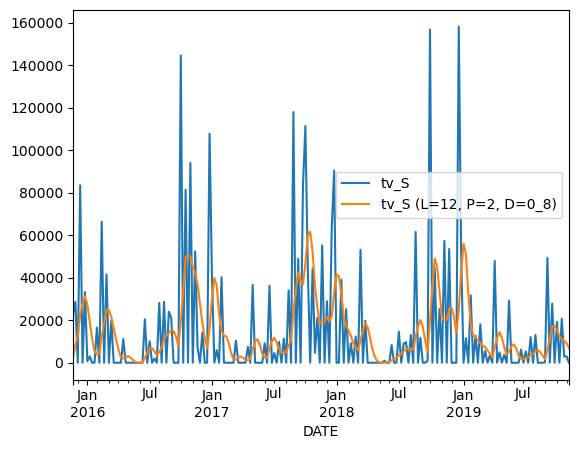

In [20]:
# Let's see the difference between the original and adstocked version
df.set_index(DATE_COL)[[x for x in df.columns if x.startswith(SPEND_COLS[0])]].plot()

### Remove incomplete rows due to feature engineering

Given that you want to understand attribution in the past, it's important that each row contains informative values. Recall that you defined some rolling satistics and lags, which naturally created missing values for the earliest rows. It's adviseable to remove these in order to create the cleanest dataset possible but not necessary.

In [21]:
# Remove rows with missing information
df_train = df_train.dropna().reset_index()
assert df_train.isnull().sum().sum() == 0, "Missing values present!"

## Modeling

Once you've prepared the data, it's time for modeling. A few considerations:

1. _Business relationships_: Marketers generally expect that increasing spend should never result in a decrease in revenue. To this end, leverage [monotonicity constraints](https://docs.datarobot.com/en/docs/modeling/analyze-models/describe/monotonic.html) to ensure this remains true in the model. Currently, only tree-based approaches (e.g., XGboost) can have monotonicity constraints applied in DataRobot.
2. _Hyperparameter tuning_: In order to give the model plenty of opportunity to see the marketing spend features in each tree split, increase the number of trees built while also searching across other relevant hyperparameters to ensure it remains performant. Too few trees may result in some marketing channels not being used at all, especially if you have a large number of them.
3. _Shapley values_: As mentioned before, use Shapley values to help you assign credit to each marketing channel. Hence, make sure that DataRobot only builds models that can generate [shap-based prediction explanations](https://docs.datarobot.com/en/docs/modeling/analyze-models/understand/pred-explain/shap-pe.html#preview-prediction-explanations).
4. _In-sample predictions_: You want to understand the training data fully, so you'll actually leverage in-sample predictions (i.e., generated on the same data the model was trained on) and prediction explanations. The in-sample fit can be assessed by reuploading the training dataset as an [external test set](https://docs.datarobot.com/en/docs/api/guide/python/modeling/insights/external_testset.html#requesting-external-scores-and-insights) and out-of-sample fit via [DataRobot's leaderboard](https://docs.datarobot.com/en/docs/workbench/wb-experiment/manage-experiments/leaderboard.html#model-leaderboard).

### Model building

In [22]:
# Make a DataRobot project
project = dr.Project.create(
    sourcedata=df_train,
    project_name="Marketing Attribution Example",
)
project

Project(Marketing Attribution Example)

In [23]:
# Get lists of features
features = [
    x
    for x in project.get_featurelist_by_name(name="Informative Features").features
    if x not in [TARGET_COL, f"{DATE_COL} (Year)"]
]
adstock_features = [x for x in df_train.columns if "(L" in x]
non_adstock_features = [x for x in features if x not in adstock_features]

# Organize the groups
feature_groups = {
    "all_features": features,
    "marketing_spend_features": adstock_features,
    "non_marketing_spend_features": non_adstock_features,
}

# Make main featurelist
fl = project.create_featurelist(name="Predictors", features=feature_groups["all_features"])

# Make monotonic featurelist
mono_up_fl = project.create_featurelist(
    name="Mono Up", features=feature_groups["marketing_spend_features"]
)

print("Features:", fl.features)
print("Adstock Features:", mono_up_fl.features)

Features: ['DATE (Day of Month)', 'DATE (Month)', 'competitor_sales_B', 'revenue (1 week ago)', 'revenue (4 weeks ago)', 'revenue (12 weeks ago)', 'revenue (4 week average)', 'revenue (12 week average)', 'Event (Days Until Next)', 'Event (Next Name)', 'facebook_S (L=4, P=0, D=0_6)', 'ooh_S (L=8, P=3, D=0_6)', 'print_S (L=12, P=2, D=0_6)', 'search_S (L=12, P=0, D=0_8)', 'tv_S (L=12, P=2, D=0_8)']
Adstock Features: ['facebook_S (L=4, P=0, D=0_6)', 'ooh_S (L=8, P=3, D=0_6)', 'print_S (L=12, P=2, D=0_6)', 'search_S (L=12, P=0, D=0_8)', 'tv_S (L=12, P=2, D=0_8)']


In [24]:
# Kick project off
project.analyze_and_model(
    target=TARGET_COL,
    mode=dr.enums.AUTOPILOT_MODE.MANUAL,
    metric="RMSE",
    worker_count=-1,
    featurelist_id=fl.id,
    advanced_options=dr.AdvancedOptions(
        monotonic_increasing_featurelist_id=mono_up_fl.id,
        only_include_monotonic_blueprints=True,
        shap_only_mode=True,
    ),
    max_wait=60 * 60 * 24,
    partitioning_method=dr.DatetimePartitioningSpecification(
        datetime_partition_column=DATE_COL,
        # Only using 1, as well end up retraining on all the data
        number_of_backtests=1,
        disable_holdout=True,
    ),
)

Project(Marketing Attribution Example)

In [25]:
# Get a blueprint (feel free to experiment with the set of blueprints available)
blueprint = [
    x
    for x in project.get_blueprints()
    if x.model_type == "eXtreme Gradient Boosted Trees Regressor"
][0]

# Train it
model_job = project.train_datetime(
    blueprint_id=blueprint.id,
    featurelist_id=fl.id,
    monotonic_increasing_featurelist_id=mono_up_fl.id,
)

# Get model when finished
model = model_job.get_result_when_complete(max_wait=60 * 60 * 24)
model

DatetimeModel('eXtreme Gradient Boosted Trees Regressor')

In [26]:
# Now rebuild it with adjusted hyperparameters

# Start tuning session
tune = model.start_advanced_tuning_session()

# Now change hyperparameters
tune.set_parameter(
    parameter_name="n_estimators",
    value=1000,
)
tune.set_parameter(
    parameter_name="learning_rate",
    value=[0.01, 0.02, 0.03, 0.04, 0.05],
)
tune.set_parameter(
    parameter_name="max_depth",
    value=[2, 3, 4],
)
tune.set_parameter(
    parameter_name="colsample_bytree",
    value=[0.2, 0.4, 0.6, 0.8, 1],
)
tune.set_parameter(
    parameter_name="subsample",
    value=[0.6, 0.8, 1],
)

# Save tuning job
model_job = tune.run()

In [27]:
# Get the model
model = model_job.get_result_when_complete(max_wait=60 * 60 * 24)

# Get date feature
date_feature = [x for x in project.get_modeling_features() if x.name == DATE_COL][0]

# Now retrain on all the data
model_job = model.request_frozen_datetime_model(
    training_start_date=pd.Timestamp(date_feature.min),
    training_end_date=pd.Timestamp(date_feature.max) + pd.Timedelta("1d"),
)

# Wait to finish
final_model = model_job.get_result_when_complete(max_wait=60 * 60 * 24)

# Compute shap impact
ShapImpact.compute(entity_id=final_model.id, source="training")

# Request feature effects (to demonstrate the monotonicity contraints)
final_model.request_feature_effect(
    backtest_index=final_model.get_feature_effect_metadata().data[0].backtest_index
)

Job(featureEffects, status=queue)

In [28]:
# Pass back to the model
dr_pred_data = project.upload_dataset(sourcedata=df_train)
model_job = final_model.request_external_test(
    dataset_id=dr_pred_data.id, actual_value_column=project.target
)

# Wait
model_job.wait_for_completion(max_wait=60 * 60 * 24)

# Check in-sample R2 to inspect in-sample fit
insample_scores = dr.ExternalScores.list(
    project_id=project.id,
    dataset_id=dr_pred_data.id,
)
insample_scores = [x for x in insample_scores if x.model_id == final_model.id][0]
print(
    f"In-sample R^2 for {TARGET_COL}:",
    [x["value"] for x in insample_scores.scores if x["label"] == "R Squared"][0],
)

In-sample R^2 for revenue: 0.99709


In [29]:
# Check out-of-sample R2
print(
    f"Out-of-sample R^2 for {TARGET_COL}:",
    model.metrics["R Squared"]["validation"],
)

Out-of-sample R^2 for revenue: 0.95081


In [30]:
# Verify that all the marketing spend features used
shap_data = ShapImpact.get(entity_id=final_model.id, source="training").data["shap_impacts"]
zero_impact = [x["feature_name"] for x in shap_data if x["impact_normalized"] <= 0]

# Do the assertion
zero_impact_spend = [x for x in zero_impact if x in adstock_features]
assert (
    len(zero_impact_spend) == 0
), f"{key} model contains zero impact marketing spend features! See {zero_impact_spend}"

### Model deployment

In [31]:
# Register model and wait until it's finished building
registered_model_version = dr.RegisteredModelVersion.create_for_leaderboard_item(final_model.id)
registered_model_id = registered_model_version.registered_model_id
registered_model_version_id = registered_model_version.id

# Poll until finished
max_attempts = 1000
for attempt in range(max_attempts):
    registered_model = dr.RegisteredModel.get(registered_model_id)
    registered_model_version = registered_model.get_version(registered_model_version_id)

    if registered_model_version.build_status == "complete":
        break

    if attempt < max_attempts - 1:  # Don't sleep after the last attempt
        time.sleep(1)
else:
    # This runs if the loop completes without breaking
    print(f"Build did not complete after {max_attempts} attempts")

In [32]:
# Get serverless environment
serverless_env = [x for x in dr.PredictionEnvironment.list() if x.name == "Severless"][0]

# Make deployment
deployment = dr.Deployment.create_from_registered_model_version(
    model_package_id=registered_model_version.id,
    label=f"{TARGET_COL} model for attribution",
    description=f"{TARGET_COL} model trained through {date_feature.max} (project: {project.id})",
    prediction_environment_id=serverless_env.id,
    max_wait=60 * 60 * 24,
)
deployment

Deployment(revenue model for attribution)

## Derive historical attribution

### Make predictions with and without marketing spend

Now that you have a model deployed, you can begin using it to better understand the historical data. While you know what the marketing strategy was and the actual revenue realized each day in the past, you don't have a way to determine how much of this revenue can be attributed to the marketing strategy. One approach for doing this is to use the model to evaulate what revenue would have been _had you spent $0 across all marketing channels of interest_ (aka the `Baseline`). The difference in revenue between when no spending occurred and what was actually realized can act as our estimate of revenue gained due to the marketing strategy (aka the `Marketing Effect`). In essence, the model is allowing us to evaluate a scenario that otherwise would be impossible. Once we generate the these two new columns, we apply a simple normalization scheme to ensure it sums to the actual revenue value for that day (since the in-sample revenue prediction won't be exactly the same). If you're deriving attribution beyond the training data, you wouldn't need to do this step since `Baseline` + `Marketing Effect` would already sum to your model's prediction.

In [33]:
# Get number of features used
n_features_used = len(fl.features)
n_features_used

15

In [34]:
# Score data as-is
job, df_pred_w_marketing_spend = dr.BatchPredictionJob.score_pandas(
    deployment=deployment,
    df=df_train,
    max_explanations=n_features_used,
    column_names_remapping={f"{TARGET_COL}_PREDICTION": f"Predicted {TARGET_COL}"},
)
df_pred_w_marketing_spend

Streaming DataFrame as CSV data to DataRobot
Created Batch Prediction job ID 68a8d90379f276b243c77f81
Waiting for DataRobot to start processing
Job has started processing at DataRobot. Streaming results.


,DATE,revenue,competitor_sales_B,revenue (1 week ago),revenue (4 weeks ago),revenue (12 weeks ago),revenue (4 week average),revenue (12 week average),Event (Days Until Next),Event (Next Name),"facebook_S (L=4, P=0, D=0_6)","ooh_S (L=8, P=3, D=0_6)","print_S (L=12, P=2, D=0_6)","search_S (L=12, P=0, D=0_8)","tv_S (L=12, P=2, D=0_8)",Predicted revenue,EXPLANATION_1_FEATURE_NAME,EXPLANATION_1_STRENGTH,EXPLANATION_1_ACTUAL_VALUE,EXPLANATION_1_QUALITATIVE_STRENGTH,EXPLANATION_2_FEATURE_NAME,EXPLANATION_2_STRENGTH,EXPLANATION_2_ACTUAL_VALUE,EXPLANATION_2_QUALITATIVE_STRENGTH,EXPLANATION_3_FEATURE_NAME,EXPLANATION_3_STRENGTH,EXPLANATION_3_ACTUAL_VALUE,EXPLANATION_3_QUALITATIVE_STRENGTH,EXPLANATION_4_FEATURE_NAME,EXPLANATION_4_STRENGTH,EXPLANATION_4_ACTUAL_VALUE,EXPLANATION_4_QUALITATIVE_STRENGTH,EXPLANATION_5_FEATURE_NAME,EXPLANATION_5_STRENGTH,EXPLANATION_5_ACTUAL_VALUE,EXPLANATION_5_QUALITATIVE_STRENGTH,EXPLANATION_6_FEATURE_NAME,EXPLANATION_6_STRENGTH,EXPLANATION_6_ACTUAL_VALUE,EXPLANATION_6_QUALITATIVE_STRENGTH,EXPLANATION_7_FEATURE_NAME,EXPLANATION_7_STRENGTH,EXPLANATION_7_ACTUAL_VALUE,EXPLANATION_7_QUALITATIVE_STRENGTH,EXPLANATION_8_FEATURE_NAME,EXPLANATION_8_STRENGTH,EXPLANATION_8_ACTUAL_VALUE,EXPLANATION_8_QUALITATIVE_STRENGTH,EXPLANATION_9_FEATURE_NAME,EXPLANATION_9_STRENGTH,EXPLANATION_9_ACTUAL_VALUE,EXPLANATION_9_QUALITATIVE_STRENGTH,EXPLANATION_10_FEATURE_NAME,EXPLANATION_10_STRENGTH,EXPLANATION_10_ACTUAL_VALUE,EXPLANATION_10_QUALITATIVE_STRENGTH,EXPLANATION_11_FEATURE_NAME,EXPLANATION_11_STRENGTH,EXPLANATION_11_ACTUAL_VALUE,EXPLANATION_11_QUALITATIVE_STRENGTH,EXPLANATION_12_FEATURE_NAME,EXPLANATION_12_STRENGTH,EXPLANATION_12_ACTUAL_VALUE,EXPLANATION_12_QUALITATIVE_STRENGTH,EXPLANATION_13_FEATURE_NAME,EXPLANATION_13_STRENGTH,EXPLANATION_13_ACTUAL_VALUE,EXPLANATION_13_QUALITATIVE_STRENGTH,EXPLANATION_14_FEATURE_NAME,EXPLANATION_14_STRENGTH,EXPLANATION_14_ACTUAL_VALUE,EXPLANATION_14_QUALITATIVE_STRENGTH,EXPLANATION_15_FEATURE_NAME,EXPLANATION_15_STRENGTH,EXPLANATION_15_ACTUAL_VALUE,EXPLANATION_15_QUALITATIVE_STRENGTH,SHAP_BASE_VALUE,SHAP_REMAINING_TOTAL,DEPLOYMENT_APPROVAL_STATUS
0,2016-02-15,1.952740e+06,5822926,1.809058e+06,2.012520e+06,2.754372e+06,1.833199e+06,2.292964e+06,-39.0,Good Friday,2079.400840,11199.844257,4113.897825,1596.258653,12327.137922,1931090.500,competitor_sales_B,181873.671875,5822926.0,NaN,"print_S (L=12, P=2, D=0_6)",11263.363281,4113.897824957047,NaN,"facebook_S (L=4, P=0, D=0_6)",-11179.757812,2079.400839660695,NaN,Event (Days Until Next),-10212.931641,-39.0,NaN,revenue (12 weeks ago),-9286.684570,2754371.66666667,NaN,"search_S (L=12, P=0, D=0_8)",-8261.704102,1596.2586530878452,NaN,DATE (Day of Month),-4745.031250,15,NaN,Event (Next Name),-3693.280029,Good Friday,NaN,"ooh_S (L=8, P=3, D=0_6)",-3285.790283,11199.844257158433,NaN,DATE (Month),-3003.983398,2,NaN,revenue (12 week average),2727.154297,2292963.7500000014,NaN,revenue (1 week ago),2724.822510,1809058.33333333,NaN,revenue (4 weeks ago),-2098.999268,2012520.0,NaN,revenue (4 week average),-1790.693359,1833199.1666666674,NaN,"tv_S (L=12, P=2, D=0_8)",-1759.073242,12327.137922396949,NaN,1791819.625,-0.208008,APPROVED
1,2016-02-22,1.507805e+06,5027123,1.952740e+06,1.738912e+06,2.584277e+06,1.818254e+06,2.226161e+06,-32.0,Good Friday,765.143210,17156.258915,3116.527242,661.075666,18497.754442,1549882.125,competitor_sales_B,-258126.578125,5027123.0,NaN,"tv_S (L=12, P=2, D=0_8)",57201.070312,18497.754442173693,NaN,Event (Days Until Next),22805.154297,-32.0,NaN,"search_S (L=12, P=0, D=0_8)",-18259.800781,661.0756663561548,NaN,Event (Next Name),-15696.570312,Good Friday,NaN,revenue (4 weeks ago),-12293.269531,1738911.66666667,NaN,revenue (12 weeks ago),-9382.424805,2584276.66666667,NaN,"print_S (L=12, P=2, D=0_6)",8864.144531,3116.5272415094787,NaN,"ooh_S (L=8, P=3, D=0_6)",-4055.121094,17156.25891477058,NaN,DATE (Day of Month),-3871.620361,22,NaN,DATE (Month),-3628.117920,2,NaN,"facebook_S (L=4, P=0, D=0_6)",-3252.482422,765.1432101660359,NaN,reve

In [35]:
# Score data with zero marketing spend
df_train_zero = df_train.copy()
df_train_zero[feature_groups["marketing_spend_features"]] = 0

# No need for shap values here, just need the prediction
job, df_pred_wo_marketing_spend = dr.BatchPredictionJob.score_pandas(
    deployment=deployment,
    df=df_train_zero,
    column_names_remapping={f"{TARGET_COL}_PREDICTION": "Baseline"},
)
df_pred_wo_marketing_spend

Streaming DataFrame as CSV data to DataRobot
Created Batch Prediction job ID 68a8d956b7b45738a8d04dd2
Waiting for DataRobot to start processing
Job has started processing at DataRobot. Streaming results.


,DATE,revenue,competitor_sales_B,revenue (1 week ago),revenue (4 weeks ago),revenue (12 weeks ago),revenue (4 week average),revenue (12 week average),Event (Days Until Next),Event (Next Name),"facebook_S (L=4, P=0, D=0_6)","ooh_S (L=8, P=3, D=0_6)","print_S (L=12, P=2, D=0_6)","search_S (L=12, P=0, D=0_8)","tv_S (L=12, P=2, D=0_8)",Baseline,DEPLOYMENT_APPROVAL_STATUS
0,2016-02-15,1.952740e+06,5822926,1.809058e+06,2.012520e+06,2.754372e+06,1.833199e+06,2.292964e+06,-39.0,Good Friday,0,0,0,0,0,1769266.000,APPROVED
1,2016-02-22,1.507805e+06,5027123,1.952740e+06,1.738912e+06,2.584277e+06,1.818254e+06,2.226161e+06,-32.0,Good Friday,0,0,0,0,0,1371771.750,APPROVED
2,2016-02-29,1.510392e+06,4561518,1.507805e+06,1.772307e+06,2.547387e+06,1.760478e+06,2.136455e+06,-25.0,Good Friday,0,0,0,0,0,1317335.750,APPROVED
3,2016-03-07,1.588840e+06,4996211,1.510392e+06,1.809058e+06,2.875220e+06,1.694999e+06,2.050039e+06,-18.0,Good Friday,0,0,0,0,0,1386455.625,APPROVED
4,2016-03-14,1.605990e+06,4938630,1.588840e+06,1.952740e+06,2.215953e+06,1.639944e+06,1.942841e+06,-11.0,Good Friday,0,0,0,0,0,1387948.125,APPROVED
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,2019-10-14,2.456240e+06,7612762,2.505162e+06,2.575148e+06,1.278223e+06,2.466720e+06,1.966783e+06,11.0,German Unity Day,0,0,0,0,0,2180028.750,APPROVED
192,2019-10-21,2.182825e+06,6701667,2.456240e+06,2.510952e+06,1.500828e+06,2.436993e+06,2.064951e+06,18.0,German Unity Day,0,0,0,0,0,1945085.000,APPROVED
193,2019-10-28,2.377707e+06,7688920,2.182825e+06,2.275620e+06,1.843118e+06,2.354962e+06,2.121784e+06,25.0,German Unity Day,0,0,0,0,0,2223135.750,APPROVED
194,2019-11-04,2.732825e+06,8815710,2.377707e+06,2.505162e+06,1.443773e+06,2.380483e+06,2.166333e+06,32.0,German Unity Day,0,0,0,0,0,2535022.750,APPROVED


In [36]:
# Subtract the predictions
df_pred_incremental = df_pred_w_marketing_spend[
    [DATE_COL, TARGET_COL, f"Predicted {TARGET_COL}"]
].join(df_pred_wo_marketing_spend[["Baseline"]])

# Compute the marketing effect
df_pred_incremental["Marketing Effect"] = (
    df_pred_incremental[f"Predicted {TARGET_COL}"] - df_pred_incremental["Baseline"]
)

# Drop the prediction column as we no longer need it
# (since we're deriving historical attribution, we'll ensure we sum to the target)
df_pred_incremental = df_pred_incremental.drop(f"Predicted {TARGET_COL}", axis=1)
df_pred_incremental

,DATE,revenue,Baseline,Marketing Effect
0,2016-02-15,1.952740e+06,1769266.000,161824.500
1,2016-02-22,1.507805e+06,1371771.750,178110.375
2,2016-02-29,1.510392e+06,1317335.750,199317.625
3,2016-03-07,1.588840e+06,1386455.625,184701.000
4,2016-03-14,1.605990e+06,1387948.125,170723.875
...,...,...,...,...
191,2019-10-14,2.456240e+06,2180028.750,277294.000
192,2019-10-21,2.182825e+06,1945085.000,234361.750
193,2019-10-28,2.377707e+06,2223135.750,156733.500
194,2019-11-04,2.732825e+06,2535022.750,177288.500


In [37]:
# Since this is historical attribution, we want to ensure Baseline + Marketing Effect = the target value
df_pred_incremental_norm = apply_normalization(
    df=df_pred_incremental,
    sum_column=TARGET_COL,
    columns_to_use=["Baseline", "Marketing Effect"],
)
df_pred_incremental_norm

,DATE,revenue,Baseline,Marketing Effect
0,2016-02-15,1.952740e+06,1.789101e+06,163638.718191
1,2016-02-22,1.507805e+06,1.334530e+06,173274.928232
2,2016-02-29,1.510392e+06,1.311897e+06,198494.715261
3,2016-03-07,1.588840e+06,1.402060e+06,186779.810600
4,2016-03-14,1.605990e+06,1.430083e+06,175906.692371
...,...,...,...,...
191,2019-10-14,2.456240e+06,2.179068e+06,277171.818216
192,2019-10-21,2.182825e+06,1.948100e+06,234725.022276
193,2019-10-28,2.377707e+06,2.221116e+06,156591.076522
194,2019-11-04,2.732825e+06,2.554196e+06,178629.368223


In [38]:
# Verify the marketing effect should never be negative
assert (
    df_pred_incremental["Marketing Effect"] >= 0
).all(), f"Original predictions are smaller than zero-ed out predictions for model!"

### Compute incremental SHAP values

Computing the `Marketing Effect` is just half the battle. A question still remains as to which marketing channels contributed to this delta the most. This is where Shapley (SHAP) values come into play.

Recall that at a basic level, SHAP values are estimated by evaluating subsets of features and summarizing the differences in a model's predictions when doing so. Their interpretation is "given the current set of feature values, the contribution of a feature value to the difference between the actual prediction and the *mean prediction* is the estimated Shapley value" [Molnar, C. (2022)](https://christophm.github.io/interpretable-ml-book/shapley.html). Note this is compared against the mean prediction, also referred to as the base value (this is why base values are necessary to decompose a model's prediction fully). This naturally produces negative shap values, as these indicate feature values that decreased the prediction, relative to the mean prediction.

However, for marketing attribution, what you actually care about is the difference between the actual prediction and the prediction _when marketing spend is 0_. Because of this, you can't just use SHAP values directly without some post-processing. In an ideal world, while you could certainly derive SHAP-like contribution with this adjustment by hand, it'd be *very* computationally expensive, especially for a large number of marketing channels; hence, you'll approximate. There's a variety of ways to tackle this, but in this notebook, for each channel you:

1. Set the channel spend to 0.
2. Generate the SHAP value for that channel when zero-ed out.
3. Subtract the SHAP value from the original row with this new shap value from the zero-ed out exercise.

This is a similar approach to deriving the `Marketing Effect`, only now you're doing this at the SHAP-level rather than prediction-level. The resulting incremental values give us a sense of channel importance, taking into account everything else going on in that row. These, in turn, can be leveraged to know how much credit to give each channel. In addition, it gives us a natural way to remove many of the negative shap values we see, as the shap value for a zero-ed out channel is generally lower than when the channel has some level of spend.

In [39]:
# Convert into more of the typical shap output (each feature value is the shap contribution)
df_shap_original = df_pred_w_marketing_spend.apply(lambda x: reformat_prediction_row(x), axis=1)
df_shap_original

,DATE,DATE (Day of Month),DATE (Month),DEPLOYMENT_APPROVAL_STATUS,Event (Days Until Next),Event (Next Name),Predicted revenue,SHAP_BASE_VALUE,SHAP_REMAINING_TOTAL,competitor_sales_B,"facebook_S (L=4, P=0, D=0_6)","ooh_S (L=8, P=3, D=0_6)","print_S (L=12, P=2, D=0_6)",revenue,revenue (1 week ago),revenue (12 week average),revenue (12 weeks ago),revenue (4 week average),revenue (4 weeks ago),"search_S (L=12, P=0, D=0_8)","tv_S (L=12, P=2, D=0_8)"
0,2016-02-15,-4745.031250,-3003.983398,APPROVED,-10212.931641,-3693.280029,1931090.500,1791819.625,-0.208008,181873.671875,-11179.757812,-3285.790283,11263.363281,1.952740e+06,2724.822510,2727.154297,-9286.684570,-1790.693359,-2098.999268,-8261.704102,-1759.073242
1,2016-02-22,-3871.620361,-3628.117920,APPROVED,22805.154297,-15696.570312,1549882.125,1791819.625,-0.468002,-258126.578125,-3252.482422,-4055.121094,8864.144531,1.507805e+06,-511.216553,-229.732559,-9382.424805,-1500.466675,-12293.269531,-18259.800781,57201.070312
2,2016-02-29,9405.416016,-4269.583008,APPROVED,19643.058594,-18670.396484,1516653.375,1791819.625,0.393799,-329086.875000,-3693.659912,-6544.056152,7086.543945,1.510392e+06,10591.980469,-3058.753174,-4132.032227,-2122.159424,-7618.550293,-9345.733398,66648.156250
3,2016-03-07,-11788.733398,-3358.529785,APPROVED,23491.603516,-15654.362305,1571156.625,1791819.625,-0.274033,-256345.218750,-3977.673828,-7674.250488,3106.751953,1.588840e+06,12318.483398,-286.714539,-12610.327148,84.515671,-2314.128662,-8841.368164,63187.226562
4,2016-03-14,-3650.523438,-2911.619385,APPROVED,21023.308594,-15708.692383,1558672.000,1791819.625,-0.528641,-261986.203125,-8739.919922,-32580.550781,10994.115234,1.605990e+06,9694.331055,141.893539,382.858490,-2214.319092,-2384.615967,-8396.690430,63189.531250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,2019-10-14,-10289.131836,-8647.004883,APPROVED,-34234.746094,-24434.826172,2457322.750,1791819.625,2.265015,646219.187500,105532.960938,-4260.285156,7737.415527,2.456240e+06,-701.107788,-3520.089600,-21376.861328,3997.046143,-8635.187500,36026.652344,-17913.162109
192,2019-10-21,-2897.443604,-5446.310547,APPROVED,-27314.953125,-21779.013672,2179446.750,1791819.625,3.903076,374307.937500,53093.449219,-3868.159180,8768.847656,2.182825e+06,1318.705444,-292.343018,903.082397,5403.962891,-12046.045898,34542.261719,-17070.755859
193,2019-10-28,23938.195312,-6870.712891,APPROVED,-13353.677734,-2326.750488,2379869.250,1791819.625,1.394043,666614.125000,-83836.531250,-4797.051758,7499.651855,2.377707e+06,-13180.932617,-1895.220703,3110.932129,4913.808594,-4314.100586,34324.503906,-21778.007812
194,2019-11-04,-7026.705078,1497.705078,APPROVED,411.144775,-1796.667480,2712311.250,1791819.625,1.610840,974286.437500,-105192.437500,-24543.851562,9915.124023,2.732825e+06,28544.023438,6358.604004,17836.347656,18679.382812,-2786.626709,31794.566406,-27487.033203


In [40]:
# Setting each channel to 0 one-by-one
for channel in feature_groups["marketing_spend_features"]:
    print(f"Deriving attribution for {channel}...")

    # Create 0 channel spend dataset
    df_train_minus_channel = df_train.copy()
    df_train_minus_channel[channel] = 0

    # Prediction request
    job, df_pred_minus_channel = dr.BatchPredictionJob.score_pandas(
        deployment=deployment,
        df=df_train_minus_channel,
        max_explanations=n_features_used,
    )

    # Reformat
    df_shap_minus_channel = df_pred_minus_channel.apply(
        lambda x: reformat_prediction_row(x), axis=1
    )

    # Add to incremental dataframe
    df_pred_incremental[channel] = df_shap_original[channel] - df_shap_minus_channel[channel]

    print("\n")

# Check
df_pred_incremental

Deriving attribution for facebook_S (L=4, P=0, D=0_6)...
Streaming DataFrame as CSV data to DataRobot
Created Batch Prediction job ID 68a8d988b7b45738a8d04dd6
Waiting for DataRobot to start processing
Job has started processing at DataRobot. Streaming results.


Deriving attribution for ooh_S (L=8, P=3, D=0_6)...
Streaming DataFrame as CSV data to DataRobot
Created Batch Prediction job ID 68a8d9dab7b45738a8d04dde
Waiting for DataRobot to start processing
Job has started processing at DataRobot. Streaming results.


Deriving attribution for print_S (L=12, P=2, D=0_6)...
Streaming DataFrame as CSV data to DataRobot
Created Batch Prediction job ID 68a8da0ab7b45738a8d04de2
Waiting for DataRobot to start processing
Job has started processing at DataRobot. Streaming results.


Deriving attribution for search_S (L=12, P=0, D=0_8)...
Streaming DataFrame as CSV data to DataRobot
Created Batch Prediction job ID 68a8da3c25cb10a793c5bf6a
Waiting for DataRobot to start processing
Job has started pr

,DATE,revenue,Baseline,Marketing Effect,"facebook_S (L=4, P=0, D=0_6)","ooh_S (L=8, P=3, D=0_6)","print_S (L=12, P=2, D=0_6)","search_S (L=12, P=0, D=0_8)","tv_S (L=12, P=2, D=0_8)"
0,2016-02-15,1.952740e+06,1769266.000,161824.500,8152.380859,32630.123779,48100.242188,16178.186523,59244.489258
1,2016-02-22,1.507805e+06,1371771.750,178110.375,7432.857422,32796.902344,42966.671875,6087.261719,120155.609375
2,2016-02-29,1.510392e+06,1317335.750,199317.625,9920.990479,31190.689941,34777.499023,15864.442383,128525.550781
3,2016-03-07,1.588840e+06,1386455.625,184701.000,7413.582031,28502.456543,38116.451172,13424.079102,125911.710938
4,2016-03-14,1.605990e+06,1387948.125,170723.875,2569.507812,3497.609375,46552.634766,16178.188477,125326.183594
...,...,...,...,...,...,...,...,...,...
191,2019-10-14,2.456240e+06,2180028.750,277294.000,192467.804688,13109.855469,29494.948730,56961.951172,33281.982422
192,2019-10-21,2.182825e+06,1945085.000,234361.750,131834.042969,20379.334961,32609.212891,54782.613281,34191.306641
193,2019-10-28,2.377707e+06,2223135.750,156733.500,10435.453125,16308.290039,45537.694824,53546.117188,33761.226562
194,2019-11-04,2.732825e+06,2535022.750,177288.500,27794.078125,21957.433594,53210.885742,53507.195312,24934.212891


### Post-processing incremental SHAP values

Now that you have the incremental SHAP values for the marketing spend features, apply some post-processing to make sure these values are as intuitive to practioners as possible. Specifically, you will do three things:

1. Ensure any incremental value for rows with no spending in the adstock tranformed space is 0. You've already accounted for the carry-over effect in the adstock transformation so it doesn't make sense to have contribution for situations with 0 adstock spend.
2. Ensure any negative value is 0. You may wonder why you still may see negative incremental values, even after subracting out the zero effect. Note that you're using a non-linear model, so it's likely that there's a non-linear effect learned for a given row, which makes the shap value more negative in the original row than the SHAP value for the same row when it was set to 0 (though this is likely more of a rare occurrence).
3. Ensure the sum of post-processing SHAP values equals the marketing effect by using a simple normalization scheme (the same one mentioned earlier).

The result of applying these post-processing steps is the final set of contribution values that represent the portion of revenue each channel was responsible for. Note that you may find two situations when looking at row-by-row results:

1. Spending is 0 but contribution is >0.
2. Contribution is 0 but spending is >0.

The first situation can be explained due to the carry-over effect you baked in using the adstock transformation behind the scenes. For the second situation, the interpration is that there wasn't enough spend to meaningfully contribute to overall revenue when considering the other factors on that day (other marketing spend values, holiday and seasonal information, etc.) or that the peak of the effect doesn't occur until later.

In [41]:
# Apply post-processing
df_attribution = post_process_incremental_values(
    shap_incremental=df_pred_incremental,
    data=df_train,
    marketing_spend_features=feature_groups["marketing_spend_features"],
)
df_attribution

,DATE,revenue,Baseline,Marketing Effect,facebook_S,ooh_S,print_S,search_S,tv_S
0,2016-02-15,1.952740e+06,1769266.000,161824.500,8029.284338,32137.426640,47373.954665,15933.904697,58349.929660
1,2016-02-22,1.507805e+06,1371771.750,178110.375,6321.015232,27890.985594,36539.512595,5176.700138,102182.161441
2,2016-02-29,1.510392e+06,1317335.750,199317.625,8976.918864,28222.614819,31468.106706,14354.797779,116295.186832
3,2016-03-07,1.588840e+06,1386455.625,184701.000,6417.523805,24672.984341,32995.282406,11620.475343,108994.734106
4,2016-03-14,1.605990e+06,1387948.125,170723.875,2259.772364,3075.998044,40941.053765,14228.025708,110219.025120
...,...,...,...,...,...,...,...,...,...
191,2019-10-14,2.456240e+06,2180028.750,277294.000,164056.112936,11174.606230,25140.966552,48553.347972,28368.966310
192,2019-10-21,2.182825e+06,1945085.000,234361.750,112846.058323,17444.110563,27912.525906,46892.303643,29266.751564
193,2019-10-28,2.377707e+06,2223135.750,156733.500,10248.747278,16016.510365,44722.957428,52588.097151,33157.187778
194,2019-11-04,2.732825e+06,2535022.750,177288.500,27163.544897,21459.309806,52003.749769,52293.337295,24368.558233


## Summarize results

At this point, you're now ready to merge the computed information to the historical data. This will allows you to summarize these results to understand which marketing channels are our largest fraction of spend, which marketing channels contribute the most to revenue, and, finally, which marketing channels deliver the largest return on investment by computing return on ad spend (ROAS).

In [42]:
# Combine original spending and estimated contribution
df_roi = df_attribution.merge(
    df[[DATE_COL] + SPEND_COLS],
    how="left",
    on=DATE_COL,
    suffixes=(" Contribution", ""),
)

df_roi = df_roi[
    [DATE_COL, TARGET_COL, "Baseline", "Marketing Effect"]
    + SPEND_COLS
    + [x + " Contribution" for x in SPEND_COLS]
]

# Rounding for readability
df_roi = df_roi.round(2)
df_roi

,DATE,revenue,Baseline,Marketing Effect,tv_S,ooh_S,print_S,search_S,facebook_S,tv_S Contribution,ooh_S Contribution,print_S Contribution,search_S Contribution,facebook_S Contribution
0,2016-02-15,1952740.00,1769266.00,161824.50,66276.44,0.00,2448.40,0.00,1448.60,58349.93,32137.43,47373.95,15933.90,8029.28
1,2016-02-22,1507805.00,1371771.75,178110.38,0.00,0.00,0.00,0.00,0.00,102182.16,27890.99,36539.51,5176.70,6321.02
2,2016-02-29,1510391.67,1317335.75,199317.62,41556.29,0.00,0.00,2293.33,2415.60,116295.19,28222.61,31468.11,14354.80,8976.92
3,2016-03-07,1588840.00,1386455.62,184701.00,0.00,0.00,16506.09,2826.67,0.00,108994.73,24672.98,32995.28,11620.48,6417.52
4,2016-03-14,1605990.00,1387948.12,170723.88,19772.44,43994.13,0.00,2373.33,0.00,110219.03,3076.00,40941.05,14228.03,2259.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,2019-10-14,2456240.00,2180028.75,277294.00,0.00,32230.93,20496.49,14946.67,0.00,28368.97,11174.61,25140.97,48553.35,164056.11
192,2019-10-21,2182825.00,1945085.00,234361.75,20655.68,0.00,0.00,13826.67,4454.15,29266.75,17444.11,27912.53,46892.30,112846.06
193,2019-10-28,2377706.67,2223135.75,156733.50,2931.00,7516.80,2330.13,15293.33,0.00,33157.19,16016.51,44722.96,52588.10,10248.75
194,2019-11-04,2732825.00,2535022.75,177288.50,2993.73,0.00,3206.84,17880.00,0.00,24368.56,21459.31,52003.75,52293.34,27163.54


In [43]:
# Reformat data into a better format for plotting
df_plot = df_roi.melt(
    id_vars=DATE_COL, value_vars=SPEND_COLS, var_name="channel", value_name="spend"
).merge(
    df_attribution.melt(
        id_vars=DATE_COL,
        value_vars=SPEND_COLS,
        var_name="channel",
        value_name="contribution",
    ),
    how="left",
    on=[DATE_COL, "channel"],
)
df_plot

,DATE,channel,spend,contribution
0,2016-02-15,tv_S,66276.44,58349.929660
1,2016-02-22,tv_S,0.00,102182.161441
2,2016-02-29,tv_S,41556.29,116295.186832
3,2016-03-07,tv_S,0.00,108994.734106
4,2016-03-14,tv_S,19772.44,110219.025120
...,...,...,...,...
975,2019-10-14,facebook_S,0.00,164056.112936
976,2019-10-21,facebook_S,4454.15,112846.058323
977,2019-10-28,facebook_S,0.00,10248.747278
978,2019-11-04,facebook_S,0.00,27163.544897


In [44]:
# Summarize and compute metrics
df_summary = prepare_summary_data(df_plot)
df_summary

,channel,spend,contribution,spend_pct,contribution_pct,roas
0,facebook_S,406521.37,1.089272e+07,3.015463,28.402662,26.794950
2,print_S,673182.06,5.547417e+06,4.993478,14.464835,8.240589
4,tv_S,2899689.23,1.089351e+07,21.509092,28.404717,3.756785
3,search_S,1191346.67,4.137485e+06,8.837080,10.788453,3.472948
1,ooh_S,8310486.37,6.879923e+06,61.644887,17.939333,0.827860


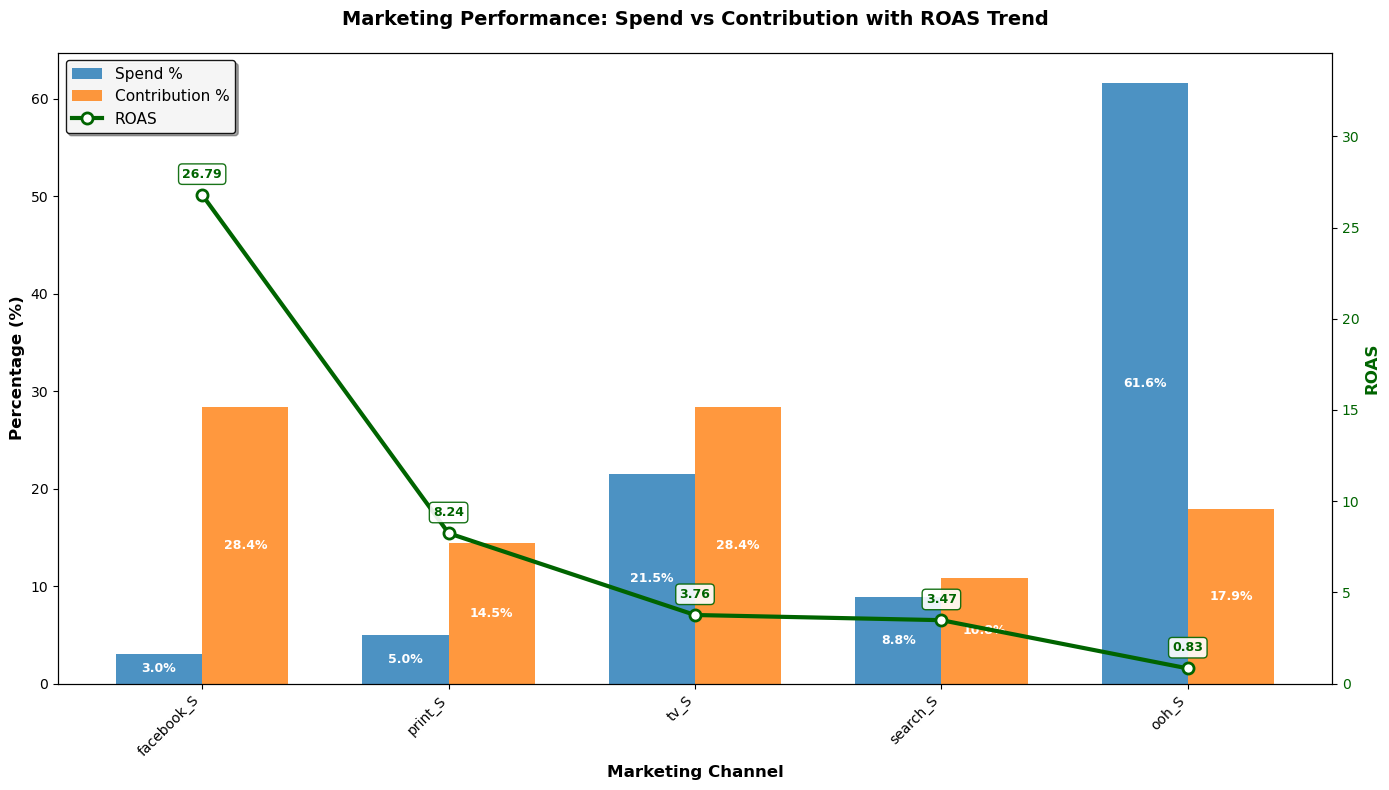

In [45]:
# Plot summary
plot_summary(df_summary)

Looking at the results, it appears that Meta is the most profitable channel and has the lowest spend relatively while out-of-home has quite the opposite pattern. These results suggest an opportunity that shifting some budget away from out-of-home spend into Meta can increase overall revenue.

In summary, the above represents one approach that users of DataRobot can take to leverage their historical data to derive attribution and inform marketing strategies. As noted, many approaches exist for deriving this attribution, each with advantages and disadvantages. What this accelerator aimed for here is something that's practical, computationally-efficient, and easy to do with the DataRobot platform. Also, while this process focuses on learning from the past, the model can be used to simulate the future by passing future marketing spend values, apply the necessary feature engineering, and deriving attribution in the same way. This simulation can inform and optimize future marketing strategies.